## Quickstart: Compare runs,choose a model,deploy it to a REST API

In this Quickstart We will : 
1. Run a  hyperparameter sweep on a training script 
2. Compare the results of the runs in the MLFLOW UI 
3. Chosse the best run and register it as a model 
4. Deploy the selected model as a REST API 
5. Build A container image suitable for deployment to a cloud platform 

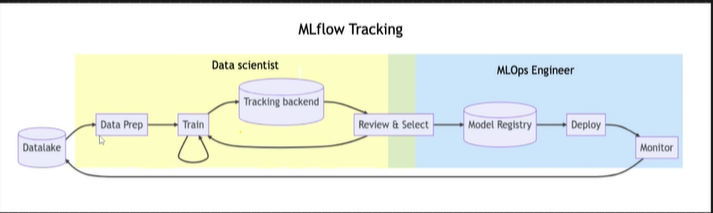

In [24]:
import keras 

In [25]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from hyperopt import STATUS_OK, Trials, fmin,hp,tpe 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import mlflow
from mlflow.models import infer_signature


""" HyperOpt is an open-source python package that uses an algorithm called Tree-based Parzen Esimtors (TPE)
 to select model hyperparameters which optimize a user-defined objective function.
  By simply defining the functional form and bounds of each hyperparameter,
 TPE thoroughly yet efficiently searches through complex hyperspace to reach optimums."""

' HyperOpt is an open-source python package that uses an algorithm called Tree-based Parzen Esimtors (TPE)\n to select model hyperparameters which optimize a user-defined objective function.\n  By simply defining the functional form and bounds of each hyperparameter,\n TPE thoroughly yet efficiently searches through complex hyperspace to reach optimums.'

In [26]:
!pip install pandas xlrd

In [27]:
## load the Dataset 

data = pd.read_excel(r"C:\Users\khair\OneDrive\Bureau\mlflow\MLOPS_Bootcamp_content-\ANN model with mlflow\concrete+compressive+strength\Concrete_Data.xls")

In [28]:
data.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [29]:
## let's rename the target column (Concrete Compressive Strength) 
data.rename(columns={'Concrete compressive strength(MPa, megapascals) ': 'Concrete_strength'}, inplace=True)

data.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),Concrete_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [30]:
data.columns

Index(['Cement (component 1)(kg in a m^3 mixture)',
       'Blast Furnace Slag (component 2)(kg in a m^3 mixture)',
       'Fly Ash (component 3)(kg in a m^3 mixture)',
       'Water  (component 4)(kg in a m^3 mixture)',
       'Superplasticizer (component 5)(kg in a m^3 mixture)',
       'Coarse Aggregate  (component 6)(kg in a m^3 mixture)',
       'Fine Aggregate (component 7)(kg in a m^3 mixture)', 'Age (day)',
       'Concrete_strength'],
      dtype='object')

In [33]:
# Split the dataset to train test 
train,test = train_test_split(data,test_size=.23, random_state=42)
train_x = train.drop(["Concrete_strength"],axis=1).values

train_y = train['Concrete_strength'].values.ravel() ## ravel to change the dimension from 2D to 1D

In [34]:
train_y

array([38.60376124, 53.77223324,  7.31534036, 32.82319446, 43.37700359,
       55.15808   , 35.22532884, 66.69990824, 30.88163004, 76.80073164,
       17.96429718, 55.06431126, 64.30053176, 33.798803  , 45.93978588,
       37.25928304, 24.84871504, 40.14818748, 13.54130864, 32.88455782,
       17.57474324, 21.53923024, 17.83674412, 23.4049523 , 55.55108132,
       17.59680647, 31.4201108 , 13.81709904, 65.90907927, 81.75116932,
       28.79941252, 42.79577532, 42.13112046, 13.33446584, 12.47262084,
       27.42046052, 32.03994972, 39.39665864, 33.39821744, 28.29609504,
       15.36152528, 41.09966436, 23.8358748 , 43.25082948, 34.56963716,
       10.22217118, 39.0932892 , 24.65566176, 22.94576128, 47.02984744,
       18.12632404, 33.39821744, 45.69846928, 31.11605188, 20.72564856,
       36.56291228, 12.45883132, 32.66047812, 38.50033984, 25.17966352,
       17.95395504, 19.1991487 , 26.200088  , 15.52010476, 11.41427518,
       60.2946762 , 69.83702404, 24.91766264, 36.3009114 , 32.32

In [39]:
test_x = test.drop(["Concrete_strength"],axis=1).values
test_y = test[["Concrete_strength"]].values.ravel()

## Vaalidation data from the training data
train_x,valid_x,train_y,valid_y = train_test_split(train_x,train_y,test_size=.2,random_state =42)

signature = infer_signature(train_x,train_y)

In [40]:
## ANN Model

def train_model(params,epochs,train_x,train_y,valid_x,valid_y,test_x,test_y):

    ## model Architecture 
    mean = np.mean(train_x,axis=0) # the mean of each column 
    var = np.var(train_x,axis=0) #
    model = keras.Sequential(
        [
            keras.Input([train_x.shape[1]]),
            keras.layers.Normalization(mean=mean, variance = var),
            keras.layers.Dense(64,activation= "relu"),
            keras.layers.Dense(1)

        ]

    )

## compile the model
    model.compile(optimizer=keras.optimizers.SGD(
        learning_rate=params["lr"],momentum = params["momentum"])
        , loss = "mean_squared_error",
        metrics=[keras.metrics.RootMeanSquaredError()]
        )

    ## Train the ANN model
    with mlflow.start_run(nested = True):
        model.fit(train_x,train_y, epochs=epochs, validation_data=(valid_x,valid_y), verbose=0)

        ## evaluate the ANN model
        eval_result = model.evaluate(valid_x, valid_y)
        eval_rmse = eval_result[1]
        ## log the hyperparameters
        mlflow.log_param("lr", params)
        mlflow.log_metric("eval_rmse",eval_rmse)

        ## log the model 
        mlflow.tensorflow.log_model(model, "model",signature = signature)
        return {"loss":eval_rmse,"status":STATUS_OK,"model": model}
       
        

In [41]:
def objective(params):
    ## Mlflow will track the parameters and results for each run 
    result = train_model(params,
        epochs=3,
        train_x=train_x,
        train_y=train_y,
        valid_x=valid_x,
        valid_y=valid_y,
        test_x=test_x,
        test_y=test_y
    )
    return result

In [42]:
space = {
    "lr":hp.loguniform("lr",np.log(1e-5),np.log(1e-1)),
    "momentum": hp.uniform("momentum",0.0,1.0)
}

In [ ]:
mlflow.set_experiment("/Concrete_Quality")
with mlflow.start_run():
    # Conduct the hyperparameter search using Hyperopt
    trials = Trials()
    best = fmin(
        fn = objective,
        space=space,
        algo = tpe.suggest,
        max_evals=4,
        trials = trials
    )

    best_run = sorted(trials.results,key=lambda x:x["loss"])[0]

    ## Log the best parameters, loss, model 
    mlflow.log_params(best)
    mlflow.log_metric("eval_rmse",best_run["loss"])
    mlflow.tensorflow.log_model(best_run["model"],"model",signature = signature)

    # Print out the best parameters and loss 
    print(f"Best parameters :{best}")
    print(f"Best eval rmse :{best_run['loss']}")

2024/11/03 13:39:45 INFO mlflow.tracking.fluent: Experiment with name '/Concrete_Quality' does not exist. Creating a new experiment.


AttributeError: type object 'type' has no attribute 'suggest'